setup

In [ ]:
# Install a pip comtradeapicall package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install --upgrade comtradeapicall

# Install a pip pandas package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas

# Install a pip matplotlib package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import comtradeapicall


subscription_key = "b5856aa064474537a609f9c773a9441d"

file_path = 'data/world_trade_by_chapter.csv'
world_trade_df = pd.read_csv(file_path)





In [ ]:
def concentration_analysis(df, flow_code, value_col, commodity_col='cmdDesc', top_n=10):
    """
    Calculate concentration indices and display top commodities for imports or exports.

    Parameters:
    - df: DataFrame containing trade data
    - flow_code: 'X' for exports or 'M' for imports
    - value_col: column name for trade values ('fobvalue' for exports, 'cifvalue' for imports)
    - commodity_col: column name for commodity description (default: 'cmdDesc')
    - top_n: number of top commodities to display (default: 10)

    Returns:
    - concentration_results: dict with Herfindahl, effective number, normalized Herfindahl
    - top_commodities: DataFrame of top commodities and their shares
    """
    # Filter by flow code
    filtered = df[df['flowCode'] == flow_code].copy()

    # Drop missing or zero values
    filtered = filtered[filtered[value_col].notna() & (filtered[value_col] > 0)]

    # Group by commodity and sum values
    grouped = filtered.groupby(commodity_col)[value_col].sum()

    # Calculate total and shares
    total = grouped.sum()
    shares = grouped / total

    # Prepare sorted DataFrame for display
    top_commodities = shares.reset_index()
    top_commodities.columns = ['Commodity', 'Share']
    top_commodities = top_commodities.sort_values(by='Share', ascending=False)

    # Print top commodities
    print(f"Top {top_n} commodities for flowCode '{flow_code}':")
    print(top_commodities.head(top_n))

    # Calculate Herfindahl Index
    H = (shares ** 2).sum()

    # Effective number of commodities
    effective_num = 1 / H if H > 0 else None

    # Normalized Herfindahl Index
    K = (shares > 0).sum()
    normalized_H = (H - 1/K) / (1 - 1/K) if K > 1 else None

    # Print results
    print(f"Herfindahl Index: {H:.4f}")
    print(f"Effective Number of Commodities: {effective_num:.2f}")
    if normalized_H is not None:
        print(f"Normalized Herfindahl Index: {normalized_H:.4f}")
    else:
        print("Normalized Herfindahl Index: Undefined (only one commodity)")

    return {
        'Herfindahl': H,
        'Effective Number': effective_num,
        'Normalized Herfindahl': normalized_H,
    }, top_commodities.head(top_n)


Všechny importy 

In [75]:
#countries

country = "203"

In [76]:
# Generate commodity chunks explicitly as comma-separated strings
def make_cmd_chunks(start, end, size=20):
    all_codes = [f"{i:02d}" for i in range(start, end + 1)]
    return [','.join(all_codes[i:i + size]) for i in range(0, len(all_codes), size)]

commodity_chunks = make_cmd_chunks(1, 99, size=20)

dfs = []

for chunk in commodity_chunks:
    df = comtradeapicall.getFinalData(
        subscription_key,
        typeCode='C',
        freqCode='A',
        clCode='HS',
        period='2023',
        reporterCode = country,
        cmdCode=chunk,
        flowCode=None,
        partnerCode=None,
        partner2Code=None,
        customsCode=None,
        motCode=None,
        maxRecords=100000,
        format_output='JSON',
        aggregateBy=None,
        breakdownMode='classic',
        countOnly=None,
        includeDesc=True
    )
    dfs.append(df)

# Combine all results into one DataFrame
full_data = pd.concat(dfs, ignore_index=True)


In [77]:
full_data.to_csv('full_data.csv', index=False)


shrnutí

In [78]:
# Total import value by partner country
imports_by_partner = full_data.groupby('partnerDesc')['cifvalue'].sum().sort_values(ascending=False)
exports_by_partner = full_data.groupby('partnerDesc')['fobvalue'].sum().sort_values(ascending=False)

print(imports_by_partner)
print(exports_by_partner)

partnerDesc
World                2.289133e+11
Germany              4.791735e+10
China                4.029322e+10
Poland               1.839820e+10
Slovakia             1.009141e+10
                         ...     
Equatorial Guinea    1.020000e+02
Curaçao              5.100000e+01
Marshall Isds        3.300000e+01
Other Africa, nes    8.000000e+00
Vanuatu              6.000000e+00
Name: cifvalue, Length: 235, dtype: float64
partnerDesc
World                                           4.751746e+11
Germany                                         1.311054e+11
China                                           4.076517e+10
Poland                                          3.692474e+10
Slovakia                                        2.970144e+10
                                                    ...     
South Georgia and the South Sandwich Islands    2.032000e+03
N. Mariana Isds                                 2.023000e+03
Antarctica                                      1.693000e+03
Saint Pie

mám rád koláče

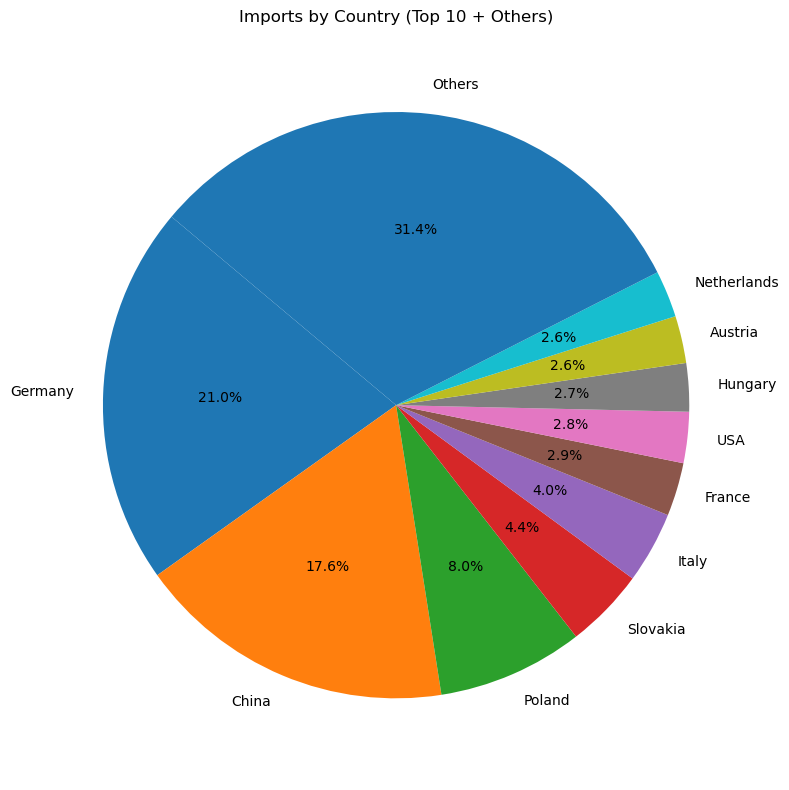

In [79]:
# Remove 'World' if present
if 'World' in imports_by_partner.index:
    imports_by_partner = imports_by_partner.drop('World')

if 'Areas, nes' in imports_by_partner.index:
    imports_by_partner = imports_by_partner.drop('Areas, nes')

# Sort descending
sorted_series = imports_by_partner.sort_values(ascending=False)

# Step 2: Top 10 countries
top_10 = sorted_series[:10]

# Step 3: Sum the rest as "Others"
others = sorted_series[10:].sum()

# Step 4: Append "Others" to the top 10
top_10_with_others = pd.concat([top_10, pd.Series({'Others': others})])

# Step 5: Plot
plt.figure(figsize=(8, 8))
plt.pie(top_10_with_others, labels=top_10_with_others.index, autopct='%1.1f%%', startangle=140)
plt.title('Imports by Country (Top 10 + Others)')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle
plt.tight_layout()
plt.show()


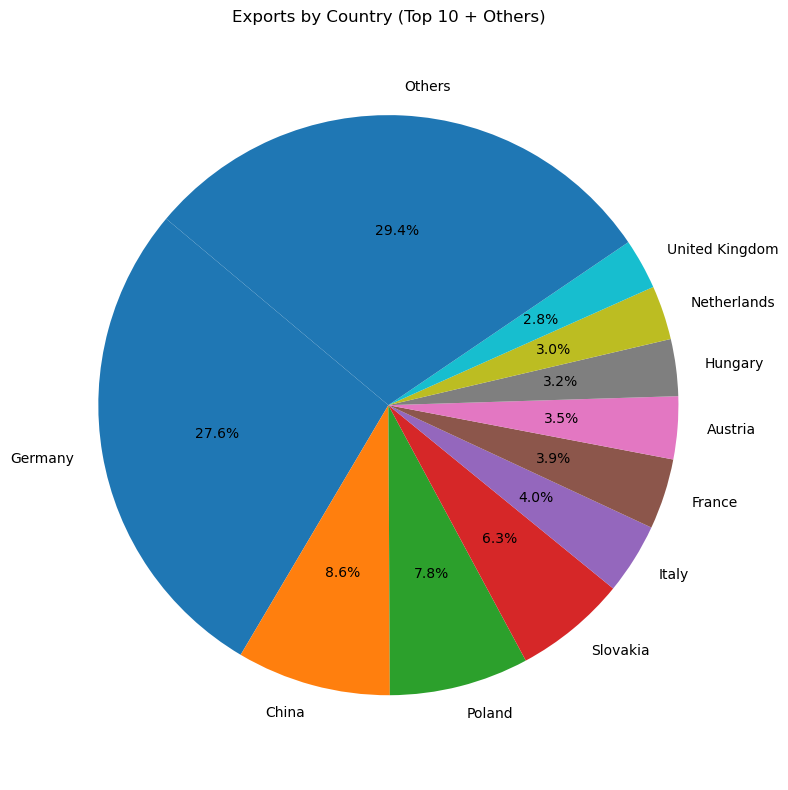

In [80]:
# Remove 'World' if present
if 'World' in exports_by_partner.index:
    exports_by_partner = exports_by_partner.drop('World')

if 'Areas, nes' in exports_by_partner.index:
    exports_by_partner = exports_by_partner.drop('Areas, nes')

# Sort descending
sorted_series = exports_by_partner.sort_values(ascending=False)

# Step 2: Top 10 countries
top_10 = sorted_series[:10]

# Step 3: Sum the rest as "Others"
others = sorted_series[10:].sum()

# Step 4: Append "Others" to the top 10
top_10_with_others = pd.concat([top_10, pd.Series({'Others': others})])

# Step 5: Plot
plt.figure(figsize=(8, 8))
plt.pie(top_10_with_others, labels=top_10_with_others.index, autopct='%1.1f%%', startangle=140)
plt.title('Exports by Country (Top 10 + Others)')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle
plt.tight_layout()
plt.show()


Další indexy

In [81]:
# For exports
export_results, export_top = concentration_analysis(full_data, flow_code='X', value_col='fobvalue')

# For imports
import_results, import_top = concentration_analysis(full_data, flow_code='M', value_col='cifvalue')


Top 10 commodities for flowCode 'X':
                                            Commodity     Share
91  Vehicles; other than railway or tramway rollin...  0.206160
23  Electrical machinery and equipment and parts t...  0.205504
43  Machinery and mechanical appliances, boilers, ...  0.170639
40                             Iron or steel articles  0.032111
64                      Plastics and articles thereof  0.032023
34  Furniture; bedding, mattresses, mattress suppo...  0.024155
58  Optical, photographic, cinematographic, measur...  0.023764
39                                     Iron and steel  0.019319
51  Mineral fuels, mineral oils and products of th...  0.019191
85  Toys, games and sports requisites; parts and a...  0.017780
Herfindahl Index: 0.1199
Effective Number of Commodities: 8.34
Normalized Herfindahl Index: 0.1107
Top 10 commodities for flowCode 'M':
                                            Commodity     Share
23  Electrical machinery and equipment and parts t...  0.22

In [85]:
# Assuming full_data is already filtered for your country (no need to filter again)
exports = full_data[full_data['flowCode'] == 'X'].copy()

# Sum export values by commodity code directly
country_exports_by_cmd = exports.groupby('cmdCode')['fobvalue'].sum()

# The rest stays the same:
total_country_exports = country_exports_by_cmd.sum()

country_exports_by_cmd.index = country_exports_by_cmd.index.astype(str).str.zfill(2)
world_trade_df['cmdCode'] = world_trade_df['cmdCode'].astype(str).str.zfill(2)

rca_df = country_exports_by_cmd.reset_index()
rca_df.columns = ['cmdCode', 'country_exports']

rca_df = rca_df.merge(world_trade_df, on='cmdCode', how='left')

total_world_exports = world_trade_df['total_trade'].sum()

rca_df['country_share'] = rca_df['country_exports'] / total_country_exports
rca_df['world_share'] = rca_df['total_trade'] / total_world_exports
rca_df['RCA'] = rca_df['country_share'] / rca_df['world_share']

rca_df['RCA'] = rca_df['RCA'].fillna(0)
rca_df = rca_df.sort_values(by='RCA', ascending=False)

print("Top 10 RCA commodities:")
print(rca_df[['cmdCode', 'RCA']].head(10))


Top 10 RCA commodities:
   cmdCode         RCA
91      93  142.474891
86      88  114.692770
70      71   55.919371
88      90   38.204934
29      30   34.626292
89      91   33.741283
83      85   32.554434
93      95   25.278739
50      51   20.221643
85      87   19.712249


In [86]:
print("Available reporter codes and descriptions:")
print(full_data[['reporterCode', 'reporterDesc']].drop_duplicates().sort_values('reporterCode'))


Available reporter codes and descriptions:
   reporterCode reporterDesc
0           203      Czechia
